#Challenge: Looking for similar patients, the AI Doctor House conquers severe COVID-19!
##Team: FrancoArgentina 
---

The task consists in the development of systems able to detect similarities among a collection of clinical case texts.

The corpus is composed of 2500 clinical cases in Spanish of COVID-19 and non COVID-19 patients. 

Our approach has been to:
1.   obtain a representation of each case in the corpus by training a LSTM autoencoder
2.   find clusters of cases by applying a HDBScan on t-SNE components computed on the encoder output
3.   check the consistency of our clusters by computing the mean pairwise distance on TF-IDF features across the cluster 
4.   gain further knowledge on the clusters by extracting the dominant topics in each cluster with Latent Dirichlet Allocation


---









##Reading the data

In [2]:
# Importing libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd

In [3]:
# Mounting Google drive where we saved our data and embeddings (not used)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Unzip all the cases txt files
# import zipfile
# with zipfile.ZipFile('drive/MyDrive/Hackaton/covid-marato-clinical-cases.zip', 'r') as zip_ref:
#     zip_ref.extractall('drive/MyDrive/Hackaton')

# Read each case txt file
import glob
import re

cases = {}
for doc in glob.glob('drive/MyDrive/Hackaton/covid-marato-clinical-cases/covid_marato*txt'):
    with open(doc, 'r') as reader:
        case_id = int(re.sub('.txt', '', re.sub('.*marato_',  '', doc)))
        cases[case_id] = re.sub('\\n', ' ', reader.read().lower())
        reader.close()
print("\nNumber of cases: ",len(cases))


Number of cases:  2500


Let's have a look at two cases

In [6]:
print("Case 2: ",cases[2])
print("\nCase 2259: ",cases[2259])

Case 2:  mujer de 32 años. refiere estreñimiento ha-bitual, en aumento durante la última temporada. la exploración física resulta anodina salvo el tacto rectal, en el que se palpa a punta de dedo una protrusión redondeada, blanda, y no dolorosa en la cara lateral derecha de la pared rectal. se solicita una ecografía abdominal apreciándose una masa de aspecto quístico y dudosa etiología de localización pararrectal derecha, de unos 34 mm de diámetro longitudinal. se solicita una rm de pelvis menor para filiar la lesión quística hallada en la ecografía, que se informa como una formación redondeada (4,8 x 2,7 cm), bien delimitada, con una cápsula fina y un contenido que muestra una intensidad de señal homogénea (tenuamente hipointenso en t2 y con una mayor señal en stir) en espacio pararrectal derecho y produciendo compresión sobre el mismo, pudiendo tratarse de una anomalía congénita. la paciente es derivada al servicio de cirugía general para tratamiento quirúrgico programado con la sosp

In [7]:
# Convert cases data to dataframe
data = pd.DataFrame.from_dict(cases, orient='index', columns=['case'])
data = data.sort_index(axis=0)
print(data.head(5))

                                                case
1  anamnesis paciente de 31 años, al que, tras un...
2  mujer de 32 años. refiere estreñimiento ha-bit...
3  niño de tres meses que presenta eritema y edem...
4  paciente de 4 años remitido a consulta de ofta...
5  anamnesis mujer sin antecedentes patológicos d...


In [9]:
from sklearn.utils import shuffle

# Shuffle the data
data = shuffle(data)

# Save the results
#data.to_csv("drive/MyDrive/Hackaton/data.csv")

In [10]:
# Load data
data = pd.read_csv("drive/MyDrive/Hackaton/data.csv",index_col=0).sort_index(axis=0)

# Save sample 990 as example in Demo 
data = data.drop(990,axis=0)
X_train = data['case'].values

#Check dimension
print("Array dimension:",np.shape(X_train))

Array dimension: (2499,)


##1. LSTM autoencoder

The encoder has 1 LSTM layer followed by a dense layer. The decoder has a bidirectionnal LSTM layer followed by a dense layer. We use Adam optimizer and categorical cross-entropy as loss.

Note: The model archicture lets the user define recurrency with timesteps but we do not make use of this possibility here. As we work with independent documents previous documents do not bear meaningful information for the next one.

In [11]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector, Bidirectional
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

# Function to define model architecture
def create_lstm_autoencoder(input_dim, timesteps, latent_dim):
    """
    Creates an LSTM Autoencoder. Returns Autoencoder, Encoder. 
    (All code by fchollet - see reference.)
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.(set to 1 here)
        latent_dim: int, latent z-layer shape. 
    # References
        - [Keras implementation of LSTM Autoencoder](https://github.com/twairball/keras_lstm_vae)
    """

    inputs = Input(shape=(timesteps, input_dim,))
    # x_embed = embedding_layer(inputs)
    encoded = LSTM(latent_dim)(inputs)
    encoded = Dense(latent_dim, activation='relu') (encoded)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = Bidirectional(LSTM(input_dim, return_sequences=True),merge_mode='sum')(decoded)
    decoded = Dense(input_dim, activation='relu') (decoded)
  
    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss="categorical_crossentropy")
    print(autoencoder.summary())
    return autoencoder, encoder

### Pre-processing

We tokenize our documents with a cutoff at 900 tokens, adding a padding when necessary and reshape our input.

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

num_words = 2000
maxlen = 900
# embed_dim = 150

# Fitting tokenizer
tokenizer = Tokenizer(num_words = num_words, split=' ')
tokenizer.fit_on_texts(X_train)

# Saving Tokenizer
with open('drive/MyDrive/Hackaton/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Encoding our cases
seqs = tokenizer.texts_to_sequences(X_train)
# Pad as sequences to max 900 words
pad_seqs = pad_sequences(seqs, maxlen)
print("oriniginal shape:", pad_seqs.shape)

# Check the number of words identified
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Reshape our data
timesteps = 1
dataX = []
for i in range(len(pad_seqs)):
    x = pad_seqs[i:(i+timesteps), :]
    dataX.append(x)
x_t_rs = np.array(dataX)
print("reshaped:", x_t_rs.shape)

oriniginal shape: (2499, 900)
Found 36846 unique tokens.
reshaped: (2499, 1, 900)


###Hyperparameters and training:

We set the dimension of the encoder output, the latent space dimension at 64. Batch size at 5 and 30 epochs.

In [14]:
batch_size = 5
latent_dim = 64

ae, encoder = create_lstm_autoencoder(maxlen, 
    timesteps= timesteps, 
    latent_dim= latent_dim)

ae.fit(x_t_rs, x_t_rs,batch_size= batch_size,
          epochs=25)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 900)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                247040    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 900)            6948000   
_________________________________________________________________
dense_3 (Dense)              (None, 1, 900)            810900    
Total params: 8,010,100
Trainable params: 8,010,100
Non-trainable params: 0
_________________________________________________

We save the network

In [16]:
# Save the models
#ae.save('drive/MyDrive/Hackaton/autoencoder_covid.h5')
#encoder.save('drive/MyDrive/Hackaton/encoder_covid.h5')

# Load the models
ae = keras.models.load_model('drive/MyDrive/Hackaton/autoencoder_covid.h5')
encoder = keras.models.load_model('drive/MyDrive/Hackaton/encoder_covid.h5', compile=False)

##2. Clustering on latent space representation
 We extract the latent space representations of the documents in the corpus (encoder output).

In [23]:
# Use the fitted encoder to get the cases representation in dimension 64 with predict 
latent_space = encoder.predict(x_t_rs)
latent_space_arr = np.asarray(latent_space)
print("Check dimension:",latent_space_arr.shape)

# Put the corpus representation in a DataFrame
cols = []
for i in range(1,65): cols.append("dim"+str(i))

latent_space_df = pd.DataFrame(data=latent_space_arr,
                               index = data.index,
                               columns=cols)
#Have look at at latent representation
latent_space_df.head()

# Save results
latent_space_df.to_csv("drive/MyDrive/Hackaton/ae_lstm_latent_space.csv")

Check dimension: (2499, 64)


We build a 2 dimensional t-SNE representation of the encoder output using cosine similarity as metric and Barnes-Hut method.


In [28]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, init='random', metric='cosine', random_state=None, method='barnes_hut')
latent_space_df = pd.read_csv("drive/MyDrive/Hackaton/ae_lstm_latent_space_with_cluster.csv",index_col=0)
tsne_results = tsne.fit_transform(latent_space_df)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2499 samples in 0.000s...
[t-SNE] Computed neighbors for 2499 samples in 0.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2499
[t-SNE] Computed conditional probabilities for sample 2000 / 2499
[t-SNE] Computed conditional probabilities for sample 2499 / 2499
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.008427
[t-SNE] KL divergence after 1000 iterations: 0.346716


We can visualize the results and see at least 8 potential clusters.

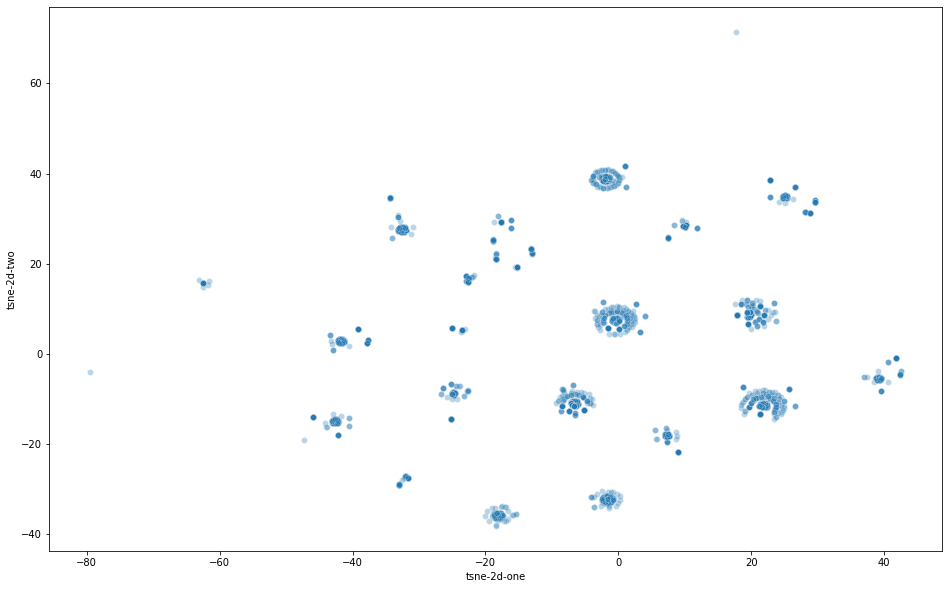

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame({"tsne-2d-one": tsne_results[:,0], "tsne-2d-two":tsne_results[:,1]})
               
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

We apply HDBScan on top of the t-SNE results with a minimum cluster size of 30 and visualize our clusters.

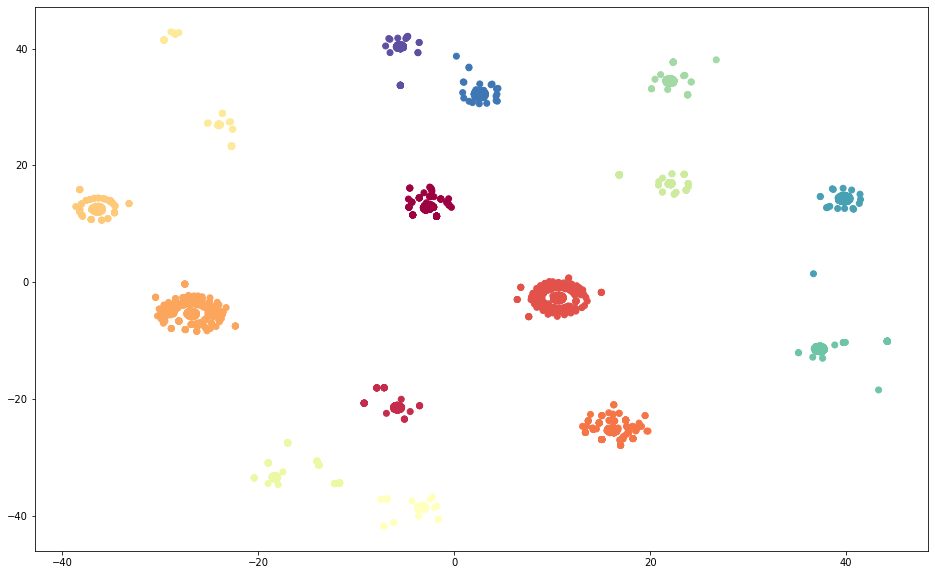

In [27]:
!pip install hdbscan
import hdbscan

# Get the clusters on t-sne results
labels = hdbscan.HDBSCAN(
    min_samples=None,
    metric = 'braycurtis',
    min_cluster_size=70,
).fit_predict(tsne_results)



# Save the cluster results
data2 = data.copy()
data2["cluster"] = labels
data2.to_csv("drive/MyDrive/Hackaton/data_with_cluster.csv")

latent_space_df2 = latent_space_df.copy()
latent_space_df2["cluster"] = labels
latent_space_df2.to_csv("drive/MyDrive/Hackaton/ae_lstm_latent_space_with_cluster.csv")


# Plot the clusters
clustered = (labels >= 0)
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[clustered, 0],
            tsne_results[clustered, 1],
            c=labels[clustered],
            cmap='Spectral');

### Alternative clustering on UMAP two dimensional representation
# import umap
# clusterable_embedding = umap.UMAP(
#     # n_neighbors=91,
#     # min_dist=0.0,
#     n_components=2,
#     random_state=42,
#     metric = 'cosine'
# ).fit_transform(latent_space_arr)

# plt.figure(figsize=(16,10))
# sns.scatterplot(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
#             palette=sns.color_palette("hls", 10));

# labels = hdbscan.HDBSCAN(
#     min_samples=None,
#     metric = 'braycurtis'
#     min_cluster_size=10,
# ).fit_predict(clusterable_embedding)

# clustered = (labels >= 0)
# plt.figure(figsize=(16,10))
# plt.scatter(clusterable_embedding[clustered, 0],
#             clusterable_embedding[clustered, 1],
#             c=labels[clustered],
#             cmap='Spectral');

We count the number of cases in each cluster.

In [30]:
count_nbcases_bycluster = data2['cluster'].value_counts()
count_nbcases_bycluster

-1     280
 4     260
 3     244
 2     228
 0     192
 5     156
 8     129
 6     127
 7     124
 11    119
 1     113
 13    112
 12    110
 9     104
 10    104
 14     97
Name: cluster, dtype: int64

##3. Consistency of clusters
We want to check the quality and consistency of our clusters. We compute the pairwise distances between all the cases texts in the corpus and average the distances within a cluster, using cosine similarity. We expect the average pairwise distances in clusters to be closer to 0 than 1.

### With TF-IDF representation of cases
We first use a traditional non-deep NLP technique, TF-IDF, to encode and vectorizse all cases. We previously tokenize, stem and remove stop words.

We first obtain Spanish stopwords and remove domain specific stopwords.

In [31]:
#Reference: http://brandonrose.org/clustering_mobile

import nltk
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('spanish')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [32]:
# Tokenize and stem
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

We vectorize with TF-IDF while tokenizing, stemming and removing stop words. We remove as well words that are either very uncommon (present in less than 25 cases) or very common (more than 2000 cases).

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.01, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
# fit tokenizer and encode our cases
%time tfidf_matrix = tfidf_vectorizer.fit_transform(data['case'].values) #fit the vectorizer to cases

print("\nCheck dimension:",tfidf_matrix.shape)



/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alguna', 'alguno', 'ant', 'desd', 'dond', 'durant', 'ello', 'entr', 'erai', 'ere', 'est', 'estabai', 'estamo', 'estaremo', 'estaréi', 'estaríai', 'estaríamo', 'estemo', 'estuv', 'estuvierai', 'estuvies', 'estuviesei', 'estuvimo', 'estuvist', 'estuvistei', 'estuviéramo', 'estuviésemo', 'estábamo', 'estái', 'estéi', 'fuerai', 'fues', 'fuesei', 'fuimo', 'fuist', 'fuistei', 'fuéramo', 'fuésemo', 'habremo', 'habréi', 'habríai', 'habríamo', 'habéi', 'habíai', 'habíamo', 'hayamo', 'hayái', 'hemo', 'hubierai', 'hubies', 'hubiesei', 'hubimo', 'hubist', 'hubistei', 'hubiéramo', 'hubiésemo', 'nosotra', 'nosotro', 'porqu', 'seamo', 'seremo', 'seréi', 'seríai', 'seríamo', 'seái', 'sient', 'sobr', 'soi', 'somo', 'tendremo', 'tendréi', 'tendríai', 'tendríamo', 'tene', 'tenemo', 'tengamo', 'tengái', 'tenéi'

CPU times: user 35.6 s, sys: 0 ns, total: 35.6 s
Wall time: 35.6 s

Check dimension: (2499, 6522)


We compute a pairwise distance matrix with cosine similarity on the vectorized documents.

In [34]:
# Get the pairwise distance matrix
from sklearn.metrics.pairwise import cosine_similarity
dist = 1- cosine_similarity(tfidf_matrix)

# Put the matrix in dataframe
dist_out = pd.DataFrame(data=dist,
                       index=data.index,
                       columns=data.index)
print('Pairwise distance matrix first rows')

dist_out.head()

Pairwise distance matrix first rows


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2461,2462,2463,2464,2465,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
1,-2.220446e-16,0.982834,0.955941,9.716732e-01,9.292825e-01,0.970703,0.937652,0.946923,0.896326,0.981128,0.963397,0.899189,0.937746,0.865745,0.869036,0.961844,0.947018,0.982284,0.918905,0.907679,0.934585,0.911408,0.933003,0.988217,0.944580,0.916844,0.937887,0.929009,0.927898,0.939389,0.940051,0.932421,0.932144,0.880276,0.956551,0.907774,0.890588,0.944670,0.975407,0.940279,...,0.980265,0.911273,0.887788,0.980484,0.894873,0.944350,0.885279,0.975685,0.960282,0.946955,0.877100,0.934697,0.973317,0.969772,0.895714,0.930734,0.956755,0.918246,0.970944,0.953517,0.936565,0.915808,0.948364,0.960529,0.940682,0.899372,0.924153,0.916091,0.945222,0.940071,0.900249,0.946650,0.890902,0.904654,0.918221,0.905351,0.889513,0.969406,0.834821,0.931787
2,9.828344e-01,0.000000,0.948836,9.741492e-01,9.664026e-01,0.987236,0.957042,0.971470,0.946183,0.952983,0.990208,0.932681,0.936189,0.947920,0.925670,0.971398,0.949999,0.979901,0.985957,0.985005,0.955758,0.936586,0.961840,0.995496,0.966663,0.839757,0.972119,0.966694,0.969656,0.961600,0.944433,0.900350,0.942972,0.980538,0.949357,0.913552,0.962945,0.983948,0.963330,0.975210,...,0.981845,0.944507,0.972748,0.970402,0.961013,0.919546,0.987555,0.983626,0.978392,0.972092,0.904248,0.979031,0.885893,0.986257,0.937301,0.973682,0.948386,0.961307,0.979041,0.878530,0.950808,0.953272,0.983832,0.938156,0.904180,0.972239,0.948552,0.927624,0.970821,0.954916,0.971574,0.959281,0.948069,0.971576,0.923143,0.959503,0.899611,0.949314,0.952058,0.987963
3,9.559405e-01,0.948836,0.000000,9.757222e-01,9.828748e-01,0.991777,0.973549,0.997465,0.952395,0.945289,0.997486,0.961069,0.931348,0.961594,0.962015,0.989872,0.959678,0.990889,0.991800,0.986909,0.963228,0.951914,0.963086,1.000000,0.975227,0.947713,0.986330,0.846854,0.966794,0.984193,0.967293,0.974101,0.985410,0.963829,0.975409,0.958193,0.942836,0.983767,0.972839,0.976025,...,0.943973,0.951313,0.973440,0.891837,0.978554,0.930756,0.975951,0.998510,0.990792,0.972467,0.942276,0.925711,0.988151,0.982941,0.964534,0.985990,0.956389,0.945124,0.977352,0.960433,0.978890,0.956996,0.982397,0.979190,0.977399,0.994073,0.976057,0.934809,0.977705,0.984784,0.972709,0.990968,0.960584,0.971770,0.977234,0.938586,0.934652,0.970333,0.965776,0.974521
4,9.716732e-01,0.974149,0.975722,-2.220446e-16,9.776792e-01,0.988562,0.906892,0.954185,0.943560,0.966812,0.978808,0.937330,0.944049,0.946768,0.886579,0.937257,0.985751,0.963673,0.986397,0.968159,0.950266,0.952310,0.961475,0.986867,0.973248,0.945709,0.963838,0.930938,0.958370,0.951021,0.962255,0.942664,0.953264,0.942508,0.971675,0.960641,0.948667,0.981813,0.975431,0.979276,...,0.824380,0.968436,0.971436,0.974394,0.957615,0.966442,0.959232,0.973792,0.983202,0.939240,0.962978,0.924993,0.968759,0.943508,0.956071,0.974730,0.967667,0.955705,0.985445,0.949279,0.974635,0.914518,0.975952,0.949037,0.955602,0.872157,0.962362,0.979984,0.970501,0.963556,0.981996,0.972607,0.957368,0.957328,0.908332,0.969773,0.955554,0.906651,0.951190,0.974323
5,9.292825e-01,0.966403,0.982875,9.776792e-01,-4.440892e-16,0.976090,0.886904,0.981444,0.839009,0.973243,0.969944,0.926826,0.956000,0.924846,0.939594,0.927550,0.965357,0.969897,0.957233,0.905069,0.950604,0.920568,0.961186,0.988686,0.937952,0.913045,0.793988,0.969995,0.936898,0.981361,0.915453,0.919297,0.965962,0.960953,0.947208,0.921136,0.938546,0.941840,0.942249,0.806718,...,0.978823,0.896694,0.864452,0.961571,0.931915,0.951470,0.980464,0.973657,0.984020,0.965965,0.907228,0.820755,0.984004,0.980348,0.926057,0.931665,0.901215,0.800747,0.978672,0.945355,0.923251,0.942542,0.923417,0.966236,0.924797,0.947581,0.925193,0.948307,0.911749,0.933325,0.945941,0.963069,0.903441,0.905393,0.953621,0.895493,0.919747,0.974899,0.871857,

We finally compute the mean pairwise distances in each cluster and see all values are close or above 0.9. Using a TF-IDF representation are clusters do not appear as consistent.

In [35]:
# Get the mean pairwise distance in each cluster
data2 = pd.concat([data2,dist_out],axis=1)

clust_nb = []
mean_pairw_dist_clust = []
for i in range(0,max(labels)+1):
  dist_mat_clust = data2.loc[data2['cluster']==i]
  cols = dist_mat_clust.index.tolist()
  mat = dist_mat_clust[cols]
  clust_nb.append(i)
  mean_pairw_dist_clust.append(mat.stack().mean())

doc_simil_clust = pd.DataFrame({'cluster':clust_nb,'mean_pairwdist':mean_pairw_dist_clust})
doc_simil_clust

,cluster,mean_pairwdist
0,0,0.947653
1,1,0.863536
2,2,0.895074
3,3,0.944087
4,4,0.923957
5,5,0.927922
6,6,0.943246
7,7,0.858424
8,8,0.873909
9,9,0.841399


###With latent representation obtained from the encoder
We then use the laten representation of our cases obtained by the encoder to compute the mean pairwise distance in each cluster. The obtains means are close to 0 in all clusters. This shows that the documents in each cluster are very similar.

In [36]:
# Get the pairwise distance matrix
dist = 1- cosine_similarity(latent_space_df.drop('cluster',axis=1))

# Put the matrix in dataframe
dist_out = pd.DataFrame(data=dist,
                      index=latent_space_df.index,
                      columns=latent_space_df.index)
# add cluster to distance matrix
dist_out['cluster'] = latent_space_df['cluster']

# Get the mean pairwise distance in each cluster
clust_nb = []
mean_pairw_dist_clust = []
for i in range(0,int(max(dist_out['cluster']))+1):
  dist_mat_clust = dist_out.loc[dist_out['cluster']==i].drop('cluster',axis=1)
  cols = dist_mat_clust.index.tolist()
  mat = dist_mat_clust[cols]
  clust_nb.append(i)
  mean_pairw_dist_clust.append(mat.stack().mean())

doc_simil_clust = pd.DataFrame({'cluster':clust_nb,'mean_pairwdist':mean_pairw_dist_clust})
doc_simil_clust.sort_values('mean_pairwdist')

,cluster,mean_pairwdist
0,0,0.000990
3,3,0.001656
12,12,0.002899
13,13,0.003179
5,5,0.003197
2,2,0.005596
4,4,0.006367
10,10,0.009949
14,14,0.012246
7,7,0.016906


##4. Dominant topics in each cluster

To get an insight in our clusters, we extract 5 15-word dominant topics in each cluster. 

For each cluster, we first pre-process our original data by tokenizing, stemming, removing stop words, very uncommon and very common words. We then extract the 5 15-word dominant topics.

A medical professional can then infer a profile from the dominat topics.

In [37]:
### Extend stopwords to remove for topic identification
# measure units
stopwords.extend(['cm','mg','tc','mg/dl','mg/m2','mm','mmol/l','ui/l','g/dl','ng/ml','dosi','u/l','cc','mg/m2','x','mmhg','mmhg','dos','mg/kg'])
# time unites
stopwords.extend(['hora','día','días','despué','ant','tras','mese','h','semana', 'desd','durant'])
# non informative 
stopwords.extend(['anamnesis','estudio','nivel','prueba','realizó','mostró','realiza','exploración','resultado','tratamiento','diagnóstico'])
stopwords.extend(['izquierdo','derecho','izquierda','derecha','zona'])
print(stopwords)


from gensim import corpora, models, similarities

clusters_topics = pd.DataFrame(columns=['cluster','topics'])
for i in range(0,max(labels)+1):
  clust_cases = data2.loc[data2['cluster']==i,'case'].tolist()

  tokenized_text = [tokenize_and_stem(text) for text in clust_cases]

  #remove stop words
  texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

  #create a Gensim dictionary from the texts
  dictionary = corpora.Dictionary(texts)

  #remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
  dictionary.filter_extremes(no_below=1, no_above=0.8)

  #convert the dictionary to a bag of words corpus for reference
  corpus = [dictionary.doc2bow(text) for text in texts]

  #fit LDA model
  lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

  #Print topics
  print("\n\nCluster",i)
  topics_matrix = lda.show_topics(formatted=False, num_words=15)
  topics_matrix = np.array(topics_matrix)
  topics = topics_matrix[:,1]
  topics_cluster_i_df = pd.DataFrame(columns=['cluster','topics'])
  topics_cluster_i_df['cluster'] = [i+1]*5
  topics_cluster_i =[]

  j = 1
  for topic in topics:
      print("\n   Topic",j,":")
      topic_j = [str(word[0]) for word in topic]
      print(topic_j)
      j+=1
      topics_cluster_i.append(topic_j)

  topics_cluster_i_df['topics'] = topics_cluster_i

  clusters_topics = pd.concat([clusters_topics,topics_cluster_i_df],axis=0)

clusters_topics.to_csv("drive/MyDrive/Hackaton/clusters_topics.csv",index=False)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 1

   Topic 1 :
['ciclo', 'negativo', 'hepática', 'pulmonar', 'presencia', 'tumor', 'ingreso', 'infiltración', 'control', 'signo', 'biopsia', 'grado', 'célula', 'dolor', 'esquema']

   Topic 2 :
['mama', 'ciclo', 'carcinoma', 'adenopatía', 'ósea', 'lesion', 'negativo', 'grado', 'metástasi', 'axilar', 'nódulo', 'biopsia', 'lesión', 'tumor', 'normal']

   Topic 3 :
['pulmonar', 'ciclo', 'progresión', 'presenta', 'adenocarcinoma', 'decid', 'metástasi', 'respuesta', 'grado', 'hepática', 'biopsia', 'inicia', 'control', 'derram', 'nódulo']

   Topic 4 :
['respuesta', 'normal', 'pulmonar', 'ciclo', 'ingreso', 'lóbulo', 'masa', 'clínica', 'grado', 'tumor', 'adenopatía', 'presenta', 'superior', 'mejoría', 'alta']

   Topic 5 :
['pulmonar', 'masa', 'tumor', 'lesión', 'dolor', 'ciclo', 'presenta', 'control', 'decid', 'hallazgo', 'inicia', 'inferior', 'part', 'carcinoma', 'clínica']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 2

   Topic 1 :
['mama', 'carcinoma', 'ductal', 'infiltrant', 'negativo', 'axilar', 'lesión', 'ósea', 'receptor', 'ciclo', 'biopsia', 'grado', 'adenopatía', 'enfermedad', 'respuesta']

   Topic 2 :
['grado', 'ósea', 'hepática', 'lesion', 'presencia', 'dolor', 'enfermedad', 'control', 'clínico', 'ingreso', 'quimioterapia', 'ciclo', 'múltipl', 'criterio', 'presenta']

   Topic 3 :
['normal', 'valor', 'alta', 'inferior', 'negativo', 'proteína', 'rm', 'positivo', 'tac', 'aumento', 'grado', 'clínica', 'ingreso', 'signo', 'enfermedad']

   Topic 4 :
['normal', 'mediant', 'colgajo', 'fiebr', 'hospitalización', 'negativo', 'sars-cov-2', 'ingreso', 'cada', 'niño', 'síntoma', 'siguient', 'rt-pcr', 'sobr', 'urgencia']

   Topic 5 :
['tumor', 'ciclo', 'pulmonar', 'masa', 'enfermedad', 'presenta', 'adenopatía', 'lesión', 'progresión', 'respuesta', 'lesion', 'inicia', 'grado', 'hallazgo', 'decid']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 3

   Topic 1 :
['evolución', 'tumor', 'masa', 'ciclo', 'adenopatía', 'carcinoma', 'metástasi', 'biopsia', 'lesión', 'complementaria', 'respuesta', 'antecedent', 'anamnesi', 'presenta', 'ósea']

   Topic 2 :
['mediant', 'alta', 'normal', 'aumento', 'volumen', 'ingreso', 'mg/24h', 'célula', 'drenaj', 'varón', 'edad', 'interna', 'dolor', 'presenta', 'lesión']

   Topic 3 :
['normal', 'dolor', 'fiebr', 'antecedent', 'ingreso', 'mediant', 'evolución', 'tac', 'cuadro', 'ojo', 'urgencia', 'negativo', 'valor', 'torácica', 'presentó']

   Topic 4 :
['ojo', 'normal', 'lesión', 'antecedent', 'renal', 'evolución', 'dolor', 'lesion', 'urgencia', 'posterior', 'presenta', 'presentaba', 'mediant', 'alta', 'masa']

   Topic 5 :
['normal', 'lesión', 'antecedent', 'evolución', 'consulta', 'clínica', 'lesion', 'inferior', 'total', 'cirugía', 'presenta', 'negativo', 'muestra', 'célula', 'control']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 4

   Topic 1 :
['normal', 'valor', 'ingreso', 'alta', 'niño', 'mediant', 'unidad', 'madr', 'segmento', 'covid-19', 'síndrome', 'pcr', 'célula', 'cuadro', 'linfoma']

   Topic 2 :
['normal', 'dolor', 'ingreso', 'valor', 'inferior', 'renal', 'negativo', 'alta', 'fiebr', 'iv', 'urgencia', 'proteína', 'analítica', 'signo', 'arteri']

   Topic 3 :
['ciclo', 'tumor', 'masa', 'adenopatía', 'enfermedad', 'grado', 'lesión', 'carcinoma', 'pulmonar', 'normal', 'biopsia', 'complementaria', 'metástasi', 'física', 'lesion']

   Topic 4 :
['masa', 'normal', 'renal', 'lesión', 'tumor', 'presenta', 'inferior', 'abdomin', 'gran', 'riñón', 'dolor', 'servicio', 'alteracion', 'superior', 'célula']

   Topic 5 :
['normal', 'alta', 'mediant', 'ingreso', 'oxígeno', 'enfermedad', 'fiebr', 'urgencia', 'oi', 'positivo', 'av', 'radiografía', 'síntoma', 'torácica', 'nasal']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 5

   Topic 1 :
['masa', 'evolución', 'ciclo', 'tumor', 'carcinoma', 'pulmonar', 'presenta', 'metástasi', 'antecedent', 'normal', 'complementaria', 'lesión', 'enfermedad', 'adenopatía', 'hallazgo']

   Topic 2 :
['normal', 'biopsia', 'lesión', 'negativo', 'enfermedad', 'presenta', 'ciclo', 'adenocarcinoma', 'evolución', 'masa', 'pulmonar', 'hepática', 'renal', 'inicia', 'hallazgo']

   Topic 3 :
['creatinina', 'cocient', 'normal', 'dolor', 'minuto', 'permanencia', 'masa', 'pase', 'cefepim', 'ui/ml', 'renal', 'alta', 'tres', 'tamaño', 'radiografía']

   Topic 4 :
['normal', 'negativo', 'posterior', 'tac', 'ingreso', 'pulmonar', 'fiebr', 'torácica', 'oxígeno', 'alta', 'lesion', 'inferior', 'antecedent', 'valor', 'covid-19']

   Topic 5 :
['normal', 'fiebr', 'od', 'madr', 'dolor', 'presentó', 'inferior', 'superior', 'froti', 'cuadro', 'sars-cov-2', 'valor', 'av', 'urgencia', 'nasofaríngeo']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 6

   Topic 1 :
['tumor', 'ciclo', 'evolución', 'dolor', 'enfermedad', 'renal', 'presenta', 'metástasi', 'progresión', 'adenopatía', 'hallazgo', 'pulmonar', 'lesión', 'lesion', 'grado']

   Topic 2 :
['renal', 'lesión', 'enfermedad', 'carga', 'control', 'arteria', 'viral', 'alteracion', 'normal', 'lesion', 'ingreso', 'presentaba', 'articular', 'ambo', 'mediant']

   Topic 3 :
['normal', 'dolor', 'antecedent', 'masa', 'cuadro', 'test', 'presentaba', 'física', 'ojo', 'control', 'sangrado', 'consulta', 'episodio', 'abdomin', 'signo']

   Topic 4 :
['lesión', 'ojo', 'superior', 'renal', 'inferior', 'evolución', 'antecedent', 'afectación', 'posteriorment', 'quimioterapia', 'dolor', 'entr', 'control', 'toma', 'varón']

   Topic 5 :
['normal', 'antecedent', 'evolución', 'enfermedad', 'edad', 'mediant', 'tumor', 'anterior', 'nódulo', 'ojo', 'tres', 'renal', 'física', 'control', 'covid-19']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 7

   Topic 1 :
['ciclo', 'presenta', 'dolor', 'enfermedad', 'pulmonar', 'grado', 'inicia', 'adenopatía', 'respuesta', 'metástasi', 'masa', 'ósea', 'decid', 'cada', 'tumor']

   Topic 2 :
['línea', 'nueva', 'médico', 'vn', 'enfermedad', 'femor', 'curso', 'momento', 'quimioterapia', 'vía', 'beneficio', 'progresión', 'alta', 'disnea', 'posibl']

   Topic 3 :
['normal', 'ciclo', 'pulmonar', 'grado', 'enfermedad', 'cuadro', 'inferior', 'tumor', 'lesion', 'hallazgo', 'ingreso', 'respuesta', 'dolor', 'compat', 'analítica']

   Topic 4 :
['lesión', 'ciclo', 'mama', 'lesion', 'pulmonar', 'tumor', 'enfermedad', 'hallazgo', 'masa', 'biopsia', 'respuesta', 'negativo', 'normal', 'metástasi', 'progresión']

   Topic 5 :
['renal', 'normal', 'tumor', 'pulmonar', 'masa', 'adenopatía', 'control', 'hallazgo', 'lesión', 'hepática', 'carcinoma', 'inferior', 'lesion', 'negativo', 'enfermedad']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 8

   Topic 1 :
['nasal', 'seno', 'lesión', 'cuadro', 'dolor', 'tumor', 'analítica', 'craneal', 'presentaba', 'opioid', 'contrast', 'est', 'ingreso', 'uci', 'part']

   Topic 2 :
['mama', 'carcinoma', 'negativo', 'lesión', 'enfermedad', 'biopsia', 'adenopatía', 'axilar', 'normal', 'lesion', 'nódulo', 'infiltrant', 'tumor', 'receptor', 'metástasi']

   Topic 3 :
['enfermedad', 'masa', 'tumor', 'cuadro', 'nueva', 'dolor', 'implant', 'alta', 'abdomin', 'muestra', 'signo', 'presenta', 'múltipl', 'oncología', 'lesion']

   Topic 4 :
['tumor', 'progresión', 'enfermedad', 'respuesta', 'grado', 'masa', 'adenopatía', 'metástasi', 'pulmonar', 'lesion', 'inicia', 'presenta', 'renal', 'seguimiento', 'decid']

   Topic 5 :
['pulmonar', 'enfermedad', 'masa', 'adenopatía', 'respuesta', 'progresión', 'presenta', 'lesión', 'grado', 'cada', 'control', 'tumor', 'carcinoma', 'hepática', 'lesion']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 9

   Topic 1 :
['negativo', 'ósea', 'signo', 'decid', 'pulmonar', 'normal', 'presenta', 'dolor', 'ingreso', 'objetiva', 'lesion', 'fiebr', 'dond', 'afectación', 'quimioterapia']

   Topic 2 :
['masa', 'normal', 'grado', 'presenta', 'dolor', 'pulmonar', 'hallazgo', 'ósea', 'decid', 'metástasi', 'negativo', 'renal', 'biopsia', 'lesion', 'quimioterapia']

   Topic 3 :
['pulmonar', 'lesión', 'masa', 'metástasi', 'presenta', 'grado', 'nódulo', 'hepática', 'lóbulo', 'mejoría', 'decid', 'normal', 'compat', 'general', 'respuesta']

   Topic 4 :
['pulmonar', 'progresión', 'respuesta', 'metástasi', 'lesión', 'adenopatía', 'lesion', 'presenta', 'línea', 'nueva', 'masa', 'hepática', 'cerebr', 'nódulo', 'inicia']

   Topic 5 :
['grado', 'lesión', 'masa', 'control', 'cada', 'pulmonar', 'carcinoma', 'dolor', 'decid', 'metástasi', 'lesion', 'adenopatía', 'presencia', 'compat', 'normal']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 10

   Topic 1 :
['masa', 'evolución', 'antecedent', 'hepática', 'tumor', 'superior', 'posterior', 'normal', 'lesión', 'control', 'abdomin', 'cuadro', 'inferior', 'quirúrgica', 'diámetro']

   Topic 2 :
['lesión', 'evolución', 'masa', 'metástasi', 'tumor', 'lesion', 'normal', 'inferior', 'ojo', 'adenopatía', 'biopsia', 'examen', 'enfermedad', 'pulmonar', 'ciclo']

   Topic 3 :
['lesion', 'lesión', 'enfermedad', 'servicio', 'colgajo', 'eritematosa', 'evolución', 'cada', 'est', 'bloqueo', 'inferior', 'arteria', 'clínica', 'planta', 'imagen']

   Topic 4 :
['normal', 'antecedent', 'pulmonar', 'covid-19', 'síntoma', 'mayo', 'fiebr', 'física', 'respiratoria', 'disminución', 'positiva', 'seguimiento', 'cirugía', 'placa', 'inferior']

   Topic 5 :
['normal', 'proteína', 'negativo', 'ingreso', 'control', 'oral', 'dolor', 'antecedent', 'alta', 'sars-cov-2', 'reveló', 'renal', 'c-reactiva', 'bilater', 'analítica']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 11

   Topic 1 :
['normal', 'negativo', 'enfermedad', 'renal', 'ciclo', 'hepático', 'analítica', 'pulmonar', 'hepática', 'presenta', 'hallazgo', 'aguda', 'ingreso', 'lesion', 'grado']

   Topic 2 :
['enfermedad', 'ciclo', 'tumor', 'carcinoma', 'presenta', 'respuesta', 'masa', 'progresión', 'control', 'metástasi', 'lesión', 'física', 'grado', 'pulmonar', 'célula']

   Topic 3 :
['vidrio', 'esmerilado', 'opacidad', 'tac', 'ósea', 'superior', 'lesion', 'biopsia', 'ingreso', 'lóbulo', 'consolidacion', 'óseo', 'adenopatía', 'compat', 'segmento']

   Topic 4 :
['presenta', 'pulmonar', 'enfermedad', 'respuesta', 'progresión', 'inicia', 'carcinoma', 'grado', 'mama', 'ciclo', 'nódulo', 'dolor', 'clínica', 'hallazgo', 'normal']

   Topic 5 :
['pulmonar', 'masa', 'enfermedad', 'normal', 'lesion', 'presenta', 'lesión', 'biopsia', 'metástasi', 'ciclo', 'respuesta', 'grado', 'evidencia', 'muestra', 'física']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 12

   Topic 1 :
['célula', 'tumoración', 'masa', 'lesión', 'presentaba', 'renal', 'tumor', 'antecedent', 'normal', 'superior', 'mediant', 'aspecto', 'onda', 'arteria', 'ojo']

   Topic 2 :
['normal', 'dolor', 'antecedent', 'abdomin', 'lesión', 'edad', 'renal', 'servicio', 'evolución', 'masa', 'control', 'ojo', 'alta', 'región', 'presentaba']

   Topic 3 :
['antecedent', 'normal', 'evolución', 'fiebr', 'ingreso', 'signo', 'dolor', 'aguda', 'clínica', 'lesion', 'negativo', 'biopsia', 'arteri', 'urgencia', 'mediant']

   Topic 4 :
['renal', 'dolor', 'colgajo', 'nasal', 'reconstrucción', 'trasplant', 'normal', 'inició', 'región', 'injerto', 'presentaba', 'hemodiálisi', 'donant', 'rodilla', 'pérdida']

   Topic 5 :
['normal', 'evolución', 'negativo', 'ingreso', 'antecedent', 'fiebr', 'presenta', 'ecografía', 'mediant', 'tac', 'alta', 'positivo', 'analítica', 'vía', 'pulmonar']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 13

   Topic 1 :
['pacient', 'normal', 'varón', 'lesión', 'ojo', 'renal', 'masa', 'antecedent', 'tamaño', 'av', 'superior', 'test', 'cirugía', 'oi', 'evolución']

   Topic 2 :
['pacient', 'normal', 'antecedent', 'lesion', 'evolución', 'mediant', 'varón', 'edad', 'control', 'consulta', 'biopsia', 'presenta', 'anterior', 'mujer', 'dolor']

   Topic 3 :
['pacient', 'presenta', 'normal', 'clínica', 'dolor', 'edad', 'mujer', 'presentó', 'colocación', 'antecedent', 'cuadro', 'mediant', 'posterior', 'realizar', 'abdomin']

   Topic 4 :
['pacient', 'evolución', 'lesión', 'dolor', 'tumoración', 'biopsia', 'ojo', 'antecedent', 'consulta', 'presentaba', 'presencia', 'abdomin', 'mujer', 'volumen', 'consistencia']

   Topic 5 :
['pacient', 'hematoma', 'antecedent', 'ingreso', 'control', 'ojo', 'orificio', 'normal', 'presenta', 'dolor', 'varón', 'drenaj', 'presentó', 'edad', 'interé']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray




Cluster 14

   Topic 1 :
['pacient', 'dolor', 'normal', 'antecedent', 'ojo', 'varón', 'consulta', 'abdomin', 'anterior', 'lesión', 'tac', 'urgencia', 'alta', 'ingreso', 'presentó']

   Topic 2 :
['pacient', 'normal', 'abdomin', 'dolor', 'presenta', 'líquido', 'antecedent', 'resto', 'signo', 'superior', 'fosa', 'edad', 'tac', 'consulta', 'renal']

   Topic 3 :
['pacient', 'abdomin', 'renal', 'masa', 'antecedent', 'evolución', 'ojo', 'ecografía', 'lesión', 'varón', 'tumoración', 'superior', 'presencia', 'ambo', 'edad']

   Topic 4 :
['pacient', 'antecedent', 'varón', 'evolución', 'clínica', 'biopsia', 'rectal', 'consulta', 'normal', 'médico', 'dond', 'grado', 'interé', 'hallazgo', 'decid']

   Topic 5 :
['pacient', 'dolor', 'ingreso', 'alta', 'evolución', 'cuadro', 'onda', 'local', 'edad', 'apertura', 'atm', 'arteri', 'unidad', 'oral', 'pediátrica']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Demo: Assigning a new case to a cluster

In [38]:
# Mounting Google drive where we saved our data and embeddings (not used)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Importing libraries
import re
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity

def find_cluster_newcase(doc = "drive/MyDrive/Hackaton/covid-marato-clinical-cases/covid_marato_990.txt"):
    case_nb = 2501
    ### Read the case
    cases_new = {}
    with open(doc, 'r') as reader:
        case_id = int(re.sub('.txt', '', re.sub('.*marato_',  '', doc)))
        cases_new[case_id] = re.sub('\\n', ' ', reader.read().lower())
        reader.close()

    print('Case',cases_new)

    X_new = pd.DataFrame.from_dict(cases_new, orient='index', columns=['case'])

    ### Encode the case with saved tokenizer


    # loading Tokenizer
    with open('drive/MyDrive/Hackaton/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # encode
    seqs = tokenizer.texts_to_sequences(X_new['case'].values)
    # pad
    maxlen = 900
    pad_seqs = pad_sequences(seqs, maxlen)
    print("original input shape:", pad_seqs.shape)

    # reshape  input
    timesteps = 1
    dataX = []
    for i in range(len(pad_seqs)):
        x = pad_seqs[i:(i+timesteps), :]
        dataX.append(x)
    x_t_rs = np.array(dataX)
    print("reshaped:", x_t_rs.shape)

    ### get the representation of the case with enncoder
    encoder = keras.models.load_model('drive/MyDrive/Hackaton/encoder_covid.h5', compile=False)
    latent_rep_x_new = encoder.predict(x_t_rs)[0].tolist()
    print("Latent representation dimension:",np.shape(latent_rep_x_new))

    print("...\n")

    ### get the distance matrix between cases in the latent space
    # load representation of the cases in corpus
    latent_space_df_with_x_new = pd.read_csv("drive/MyDrive/Hackaton/ae_lstm_latent_space_with_cluster.csv",index_col=0)
    # append new case
    latent_rep_x_new.append(np.nan)
    latent_space_df_with_x_new.loc[case_nb,:] = latent_rep_x_new

    # compute distance matrix
    dist = 1- cosine_similarity(latent_space_df_with_x_new.drop('cluster',axis=1))

    dist_out = pd.DataFrame(data=dist,
                          index=latent_space_df_with_x_new.index,
                          columns=latent_space_df_with_x_new.index)
    # add cluster to distance matrix
    dist_out['cluster'] = latent_space_df_with_x_new['cluster']

    # compute the mean distance between new case and corpus cases in each cluster
    clust_nb = []
    mean_pairw_dist_clust = []
    for i in range(0,int(max(dist_out['cluster']))+1):
      dist_mat_clust = dist_out.loc[dist_out['cluster']==i,case_nb]
      clust_nb.append(i)
      mean_pairw_dist_clust.append(dist_mat_clust.mean())

    doc_simil_clust = pd.DataFrame({'cluster':clust_nb,'mean_pairwdist':mean_pairw_dist_clust}).sort_values('mean_pairwdist').reset_index(drop=True)
    print("Top 3 clusters:\n",doc_simil_clust.head(3))
    top_cluster = doc_simil_clust['cluster'][0]

    ### get dominant topics
    topics_all_clusters = pd.read_csv("drive/MyDrive/Hackaton/clusters_topics.csv")
    topics_top_cluster = topics_all_clusters[topics_all_clusters['cluster']== top_cluster]

    print("\nTop 3 topics of top cluster:\n",topics_top_cluster.head(3)['topics'])
    return doc_simil_clust, top_cluster, topics_all_clusters, topics_top_cluster

In [40]:
simil_clust, top_cluster, topics_all_clusters, topics_top_cluster = find_cluster_newcase(doc = "drive/MyDrive/Hackaton/covid-marato-clinical-cases/covid_marato_789.txt")

Case {789: 'anamnesis mujer de 56 años, sin alergias medicamentosas conocidas ni hábitos tóxicos. como antecedentes personales, es diabética insulinodependiente y dislipémica con tratamiento médico. presenta síndrome de apnea-hipopnea del sueño, en tratamiento con ventilación mecánica no invasiva nocturna. fue colecistectomizada en 2008. no presenta antecedentes familiares oncológicos de interés. a inicios de 2011, comienza con clínica de tos y expectoración compatible con infección respiratoria. ante la persistencia de la clínica a pesar de tratamiento antibiótico, se inicia en junio de 2011 estudio diagnóstico.  exploración física ecog 1. karnofsky 80 %. buen estado general, eupneica en reposo. durante la auscultación cardiopulmonar, presenta murmullo vesicular conservado, sin ruidos patológicos sobreañadidos. el resto de la exploración se encuentra asimismo dentro de la normalidad.  pruebas complementarias analíticamente, destaca una anemia microcítica con hemoglobina de 9,8 g/dl. s

In [ ]:
# def assign_case_to_cluster(path):

#     cases_new = {}
#     with open(path, 'r') as reader:
#         case_id = int(re.sub('.txt', '', re.sub('.*marato_',  '', doc)))
#         cases_new[case_id] = re.sub('\\n', ' ', reader.read().lower())
#         reader.close()

#     data_new = pd.DataFrame.from_dict(cases_new, orient='index', columns=['case'])

#     #define vectorizer parameters
#     new_case = TfidfVectorizer(max_df=0.8, max_features=20000,
#                                     min_df=0.01, stop_words=stopwords,
#                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

#     tfidf_new_case = tfidf_vectorizer.fit_transform(data['case'].values) #fit the vectorizer to cases

#     print("\nCheck dimension of new case vectorization:",tfidf_new_case.shape)

#     tfidf_matrix_with_new_case = np.concatenate((tfidf_matrix,tfidf_new_case),axis=1)
#     dist_new = 1 - cosine_similarity(tfidf_matrix)[2500]

#     data2 = data3
#     data3["dist_new_case"] = dist_new
#     avg_dist_cluster = data3.groupby("cluster").agg(avg_dist=pd.NamedAgg(column = "dist_new_case", aggfunc = "sum"))
#     "\nAverage pairwise distance by cluster:"
#     print(avg_dist_cluster)
#     "\nAssigned to cluster:"
#     print(avg_dist_cluster.values.argmin(axis=0))
#     assigned_cluster = avg_dist_cluster.values.argmin(axis=0)
#     list_cases = list(data2[data2["cluster"]==assigned_cluster].index)
#     return assigned_cluster


# assign_case_to_cluster("drive/MyDrive/Hackaton/covid-marato-clinical-cases/covid_marato_990.txt")